--------------------------------------------------------------------------------------------------------------------------------------
### TS Roots Tutorial
--------------------------------------------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------------------------------------------------------
 In this notebook, we demonstrate the use of TS-roots for global optimization. We also demonstrate many of the design features made available to users. In addition to the sample codes, this notebook also include brief conceptual/mathematical basis of TS-roots to help user better understand the procedurial function calls.

Note: This notebook do not offer a comprehensive insights to the mathematical and algorithmetic basis of TS-roots. For well-itemized details about TS-roots, please refer to our _published jourrnal here: [link to TS-roots journal].

----------------------------------------------------------------------------------------------------------------------------------------------------

In [20]:
from tsroots.preprocessor import Hyperlearn
from tsroots.preprocessor import SE_Mercer
from tsroots.decoupled_GP import Decoupled_GP
from tsroots.optim import TSRoots
from tsroots.utils import *

import numpy as np
from IPython.display import clear_output

----------------------------------------------------------------------------------------------------------------------------------------
#### Set up Training Data
----------------------------------------------------------------------------------------------------------------------------------------
We will be using 5 training points of an underlying true function $ f = xsin(x)$ where the input x_data $x$ is normalized to the domain [-1,1] and the corresponding y_data is the z-score standardized function value (f) with added Gaussian noise. The input data points were randomly generated via Latin hypercube sampling embedded in the `generate_Xdata()` function call.

The cells below shows the data generation and normalization process towards robust computations and visualization in the normalized space.

In [21]:
# Data Parameters
D = 1  # dimension
no_sample = 5
seed = 42
noise_level = 1e-3
lb_x_physical = np.repeat(-15,1)
ub_x_physical = np.repeat(15, 1)
lb_normalized = -np.ones(D)
ub_normalized = np.ones(D)

In [22]:
# Defining the objective functiom
def f_objective_example(x):  # this can be any objective function
    return (x * np.sin(x))

# Define f_true in the normalized space, and ensure consistent scaling
X_normalized_plot = np.linspace(-1, 1, 400).reshape(-1, D)

# Unscale X_normalized to physical space for f_true evaluation
X_true_plot = unscale_Xn(X_normalized_plot, lb_x_physical, ub_x_physical)

# Compute true values in physical space
Y_true_plot = f_objective_example(X_true_plot)

# compute mean, standard deviation for z-score normalization of the output value
mean_Y_true = np.mean(Y_true_plot)
std_Y_true = np.std(Y_true_plot)

# Perform z-score normalization
Y_normalized_plot = (Y_true_plot - mean_Y_true) / std_Y_true



In [23]:
# Generate Data
X_physical_space, X_normalized = generate_Xdata(no_sample, D, seed, lb_x_physical, ub_x_physical)
Y_physical_space, _ = generate_Ydata(f_objective_example, X_physical_space)
# Add noise to output value
Y_physical_space = Y_physical_space + np.random.normal(0, noise_level)

Y_normalized = (((Y_physical_space - mean_Y_true) / std_Y_true)).flatten()

print(f"X_normalized: {X_normalized}")
print(f"Y_normalized: {Y_normalized}")

X_normalized: [[-1.        ]
 [ 0.        ]
 [ 0.66666667]
 [-0.66666667]
 [ 1.        ]]
Y_normalized: [ 1.4012227  -0.12951925 -0.98324984 -0.98324984  1.4012227 ]


Text(0.5, 1.0, 'Plot of $y = x \\sin(x)$')

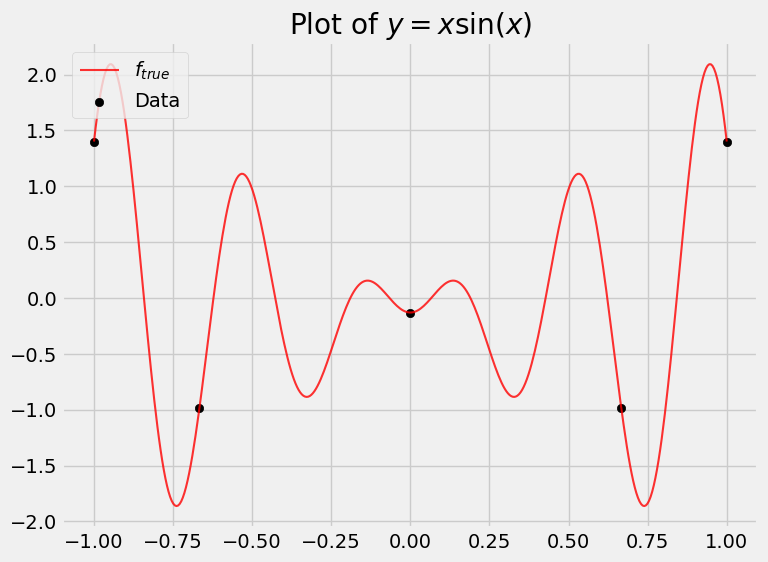

In [24]:
# Plot the true function and noisy data points
plt.figure(figsize=((8, 6)))
plt.plot(X_normalized_plot, Y_normalized_plot, linestyle="-", linewidth=1.5, color="#FF0000", alpha=.8, label=f'$f_{{true}}$')
plt.scatter(X_normalized, Y_normalized, color='black', label=r'Data')
plt.legend(loc='upper left')
plt.title(f'Plot of $y = x \sin(x)$')

---------------------------------------------------------------------------------------------------------------------------------------
#### Hyperparameters Optimization using GPyTorch
---------------------------------------------------------------------------------------------------------------------------------------
To ensure accurate computations of our GP surrogate model (used in subsequent methods), we first fit an exact GP model to our training data such that we obtain the optimal hyperparameters. This is implemented as Hyperlearn class in the preprocessor module. The Hyperlearn class is built upon GPyTorch which is a matured Gaussian Process package with automated capabilities for complex GP regression tasks.

PS: The choice of learning rate has been specifically tuned for this problem. While the robustness of TS-roots ensure convergence towards the global optimum, we advise tuning the learning rate for specific problems for optimal GP hyperparameters and function fit especially in low dimensional settings.

In [25]:
# Instantiating the Hyperlearn class
hyperlearn_instance = Hyperlearn(X_normalized, Y_normalized, noise_level=1e-3)

# Test Hyperlearn.train() and Hyperlearn.get_hyperparemeters()
hyperlearn_instance.train(num_iterations=150, learning_rate=0.07)

lengthscales, sigmaf, sigman = hyperlearn_instance.get_hyperparameters()
print(f'lengthscales, sigmaf, sigman = {lengthscales, sigmaf, sigman}')

lengthscales, sigmaf, sigman = (array([0.21859083], dtype=float32), 1.276214146797003, 0.0009999999310821295)


-----------------------------------------------------------------------------------------------------------------------------------------
#### Spectral Representation of Gaussian Process (GP)
-----------------------------------------------------------------------------------------------------------------------------------------
In TS-roots, we utilized the spectral representation of GP to construct our prior function. For this, users can optionally utilized the Preprocessor module to implement spectral sampling of GP.
In the preprocessor module, we implemented the SE_Mercer class for the spectral representations of the squared exponential based on Mercer's theorem such that:
-- the covariance function $\kappa({\bf x},{\bf x}') = \sum_{k=0}^\infty \lambda_k \phi_k(\mathbf{x}) \phi_k(\mathbf{x}')$ where $(\lambda_k, \phi_k(\mathbf{x}))$ is a pair of eigenvalue and eigenfunction of the kernel integral operator. The next cell shows the several features of the SE_Mercer class which includes the computations of:
-- hyperparameters extraction from Hyperlearn
-- parameters $a, b, c$ for the analytical computations of eigenvalues and eigenfunctions
-- the number of feature terms for the SE kernel approximation
-- eigenvalues (lambda_n) for the precomputed number of terms
-- eigenfunctions at n sample points of given x data using precomputed number of terms
-- derivative of the eigenfunctions at n sample points of given x data using precomputed number of terms



In [26]:
# Instantiating the SE_Mercer class
SE_Mercer_instance = SE_Mercer(X_normalized, Y_normalized, noise_level=noise_level, learning_rate=0.07)

# Test SE_Mercer._get_hyperparemeters()
print(f"get_hyperparameters: {SE_Mercer_instance.get_hyperparameters()}")

# Test SE_Mercer.eigen_parameters()
print(f'eigen_parameters a, b, c: {SE_Mercer_instance.eigen_parameters()}')

# Test SE_Mercer.n_terms_SE()
print(f'n_terms: {SE_Mercer_instance.n_terms_SE()}')

# Test SE_Mercer.W_array()
n_terms = SE_Mercer_instance.n_terms_SE()
print(f'Size of precomputed n feature weights across d dimension: {[k.shape for k in SE_Mercer.W_array(n_terms)]}')

# Test SE_Mercer.lambda_n()
n = n_terms[0]
print(f'size of eigenvalues (lambda_n for precomputed n terms: {SE_Mercer_instance.lambda_n(n).size}')

#Test SE_Mercer.phi() --> compute phi for one dimension (see function docstrings)
print(f'eigenfunctions (phi) for precomputed n by one dimension data size: {SE_Mercer_instance.phi(n, X_normalized[:,0]).shape}')

#Test SE_Mercer.diff_phi() --> compute phi for one dimension (see function docstrings)
print(f'diff_eigenfunctions (diff_phi) for precomputed n by one dimension data size: {SE_Mercer_instance.diff_phi(n, X_normalized[:, 0]).shape}')

get_hyperparameters: (array([0.21859083], dtype=float32), 1.276214146797003, 0.0009999999310821295)
eigen_parameters a, b, c: (0.5, 10.46420267873398, np.float64(4.602000147486738))
n_terms: [64]
Size of precomputed n feature weights across d dimension: [(64,)]
size of eigenvalues (lambda_n for precomputed n terms: 64
eigenfunctions (phi) for precomputed n by one dimension data size: (5, 64)
diff_eigenfunctions (diff_phi) for precomputed n by one dimension data size: (5, 64)


-----------------------------------------------------------------------------------------------------------------------------------------
#### Decoupled Sampling of Gaussian Process (GP)
----------------------------------------------------------------------------------------------------------------------------------------
In TS-roots, we utilized the decoupled sampling of GP to construct our posterior function.

Given a GP prior function $f(x)$ which we precompute using the spectral sampling approach, we compute the posterior function based on Matheron's rule (\cite{Wilson2020}).

PS: Feel free to skip the subsequent lines if you have limited understanding of GP or not interested in the underlying mathematics of decoupled GP sampling. The mathematical representation  of Decoupled GP is given as:
$(f|y)(\cdot) = f(\cdot) + k_{\cdot,n}(K_{n,n} + \sigma_{n}^{2}I)^{-1} (y - f_{n} - \epsilon)$
where:
$(f|y)(\cdot)$ represents the posterior, $f(\cdot)$ is the prior $f_{n} = f(x)$ and $\epsilon = (\epsilon_{i})_{i=1}^{n} \sim \mathcal{N}(0, \sigma_{n}^{2}I)$
In particular, we define the additional term (otherwise called Matheron's update) to the prior term as v_vec:
$v_{vec} = (K_{n,n} + \sigma_{n}^{2}I)^{-1} (y - f_{n} - \epsilon)$

The next couple of cells show a components wise implementation of the different terms in the above formula made available to users for precomputations.

PS: The use of TS-roots as a Bayesian optimization strategy does not require the user to perform all of these precomputations (see cells further below for a simple use of TS-roots).

#### Instantiate the Decoupled GP class and get preprocessing quantities

In [27]:
# Instantiating the Decoupled_GP class
Decoupled_GP_instance = Decoupled_GP(X_normalized, Y_normalized)

# Test Decoupled_GP.get_proprcessor()
print(f"get_proprcessor\n: {Decoupled_GP_instance.get_preprocessor()}")

get_proprcessor
: {'lengthscales_vec': array([0.21859083], dtype=float32), 'sigmaf': {1.276214146797003}, 'sigman': {0.0009999999310821295}, 'n_eigen_vec': array([64]), 'W_shape': [(64,)]}


#### Now computing the first term of the Decoupled GP representations (i.e., the GP Prior) based on spectral GP representations.
- Proceeding from the `SE_Mercer` computations of the eigenvalue $(\lambda_k)$ and eigenfunctions $(\phi_k(\mathbf{x}))$ computations, the GP prior can be written as:
- $f_\omega(\mathbf{x}) = \sum_{i=0}^{\infty} w_k \sqrt{\lambda_k} \phi_k(\mathbf{x})$, where  $w_k \overset{\text{iid}}{\sim} \mathcal{N}(0,1)$ are independent standard Gaussian random variables.

We then utilize the separability of the SE covariance function and their spectral representations to easily compute the GP Prior across multiple dimensions. For this, we simply take the product of the component univariate functions which can be denoted as:
$ f({\bf x}) \approx  \prod_{i=0}^{d} \sum_{k=1}^{N_i-1} w_{i,k} \sqrt{\lambda_{i,k}} \phi(x_i).$
The next cells show the computations of both univariate and multivariate GP prior and their corresponding derivativees.

Compute univariate GP path function values and derivatives at input locations x

In [28]:
# Test Decoupled_GP.uni_GP_path()
w = SE_Mercer.W_array(n_terms)
print(f"uni_GP_path (size n vector for n input locations): {Decoupled_GP_instance.uni_GP_path(n, X_normalized.flatten(), w[0])}")

# Test Decoupled_GP.diff_uni_GP_path()
print(f"diff_uni_GP_path (n x 1): {Decoupled_GP_instance.diff_uni_GP_path(n, X_normalized.flatten(), w[0])}")

uni_GP_path (size n vector for n input locations): [ 1.66171681 -0.46379247 -2.07813195  0.07760141 -2.78507722]
diff_uni_GP_path (n x 1): [  8.60844686   8.40163576  -6.81862161 -11.82928909   0.74846338]


Compute multivariate GP path function values and derivatives at input locations x


In [29]:
# Test Decoupled_GP_instance.multi_GP_path()
# Although X is 1D for this problem, higher dimensions can also be directly computed (see documentations).
print(f"multi_GP_path_f (size n vector for n input locations):{Decoupled_GP_instance.multi_GP_path(X_normalized)[0]}")
print(f"multi_GP_path_df (n x d):\n {Decoupled_GP_instance.multi_GP_path(X_normalized)[1]}")

multi_GP_path_f (size n vector for n input locations):[ 0.65129751 -1.72101459  0.80175808 -0.98724489 -0.1261663 ]
multi_GP_path_df (n x d):
 [[ 0.76553116]
 [ 5.10724617]
 [-3.26786609]
 [-7.53805789]
 [-2.2155118 ]]


#### Plot GP Prior

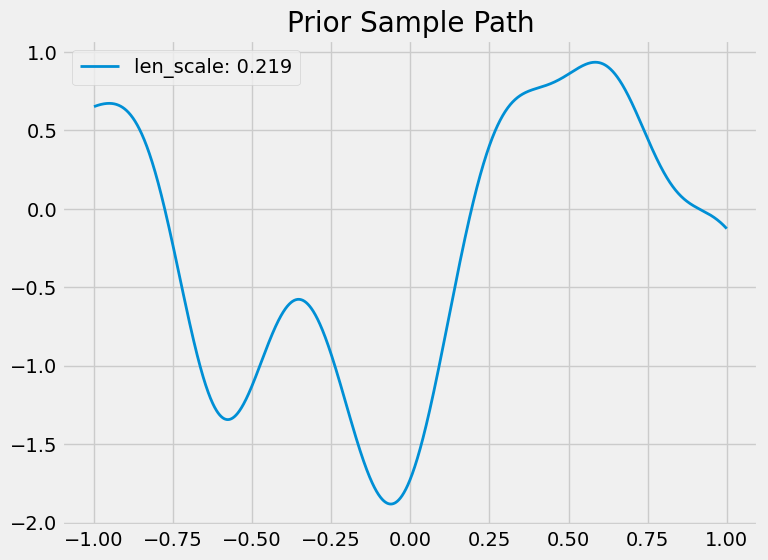

In [30]:
plot_prior_sample(Decoupled_GP_instance, lb_normalized, ub_normalized)

### Now computing the second term of the Decoupled GP posterior via Matheron's update (v_vec).
- The required kernels computation (i.e., ARD covariance, cross-covariance, and their respectively derivatives) have been implemented. See `Decoupled_GP` documentations to directly compute them if needed.
 - We recall the second term also denoted by $v_{vec}$ is given by: $(K_{n,n} + \sigma_{n}^{2}I)^{-1} (y - f_{n} - \epsilon)$ which can be directly calculated via a simple method call to an instance of the `Decoupled_GP` as shown below:


In [31]:
# Test Decoupled_GP_instance.v_vec()
v_vec = Decoupled_GP_instance.v_vec()
print(f"v_vec: {v_vec}")

v_vec: [ 0.51223033  0.99377475 -1.54870099 -0.16692989  1.42186124]


#### We can then compute the GP posterior using decoupled sampling. We also compute the corresponding derivative which is important for gradient based optimization in TS-roots algorithm.

In [32]:
# Test mixPosterior_rev
mixPosterior_func, mixPosterior_dfunc = Decoupled_GP_instance.mixPosterior(X_normalized, v_vec)
print(f'mixPosterior function values (size n vector for n input locations):\n {mixPosterior_func}')
print(f'mixPosterior derivatives (n x d):\n {mixPosterior_dfunc}')

mixPosterior function values (size n vector for n input locations):
 [ 1.40062229 -0.12903899 -0.9811545  -0.98282963  1.40108208]
mixPosterior derivatives (n x d):
 [[ 0.17350895]
 [ 4.80812497]
 [ 1.56727955]
 [-9.14190083]
 [ 3.28500832]]


#### Plot GP Posterior

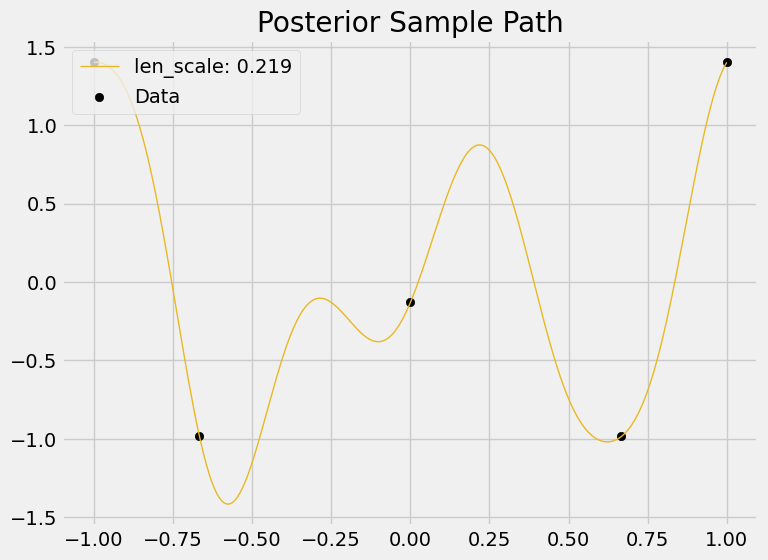

In [33]:
plot_posterior_sample(Decoupled_GP_instance, X_normalized, Y_normalized)

********* We are now set for the main part of the TS-roots package which involves the global optimization of these posterior samples.*********

-----------------------------------------------------------------------------------------------------------------------------------------
#### TS-roots: Optimizing Posterior Samples for Bayesian Optimization (BO) via Rootfinding
----------------------------------------------------------------------------------------------------------------------------------------
Bayesian Optimization (BO) uses acquisition functions $\alpha(x)$ as surrogates for expensive objective functions  $f(x)$. Thompson Sampling, a popular BO strategy, optimizes posterior samples to guide exploration and exploitation. However, optimizing these samples can be complex and computationally challenging.

TS-roots streamlines this process by leveraging the separability of the multivariate Gaussian Process prior and a decoupled representation of the posterior. Integrated with advanced root-finding techniques, TS-roots efficiently selects starting points for gradient-based multistart optimization. This results in higher-quality solutions for posterior sample-based acquisition functions, enabling robust performance in both low- and high-dimensional settings.

----------------------------------------------------------------------------------------------------------------------------------------
#### TS-roots Starting Points Selection Strategy
-----------------------------------------------------------------------------------------------------------------------------------------
(1) Utilize the separability of the multivariate GP priors: For this, we select a subset $S_{\text{e}}$ of the local minima $\breve{X}$ of the  prior sample (i.e., $S_{\text{e}} \subseteq \breve{X}$) as one set of starting points. We tagged $S_{\text{e}$ as the **Exploration Sets**. Finding the local minima of the prior samples involves calculating the critical points of the prior samples and extracting the associated local minima. We note that the critical points of the multivariate separable prior sample  are exactly the critical points of its univariate components $f_i(x_i)$, arbitrarily combined, except for when $f(\mathbf{x}) = 0$. As a result, we can find all the relevant critical points of the prior sample function $f(\mathbf{x})$ by solving a global rootfinding problem for the derivative of each of its univariate components: $f_i'(x_i) = 0$, $i \in \{1, \cdots, d\}$. This can be done efficiently via matured rootfinding algorithms that approximate the function with a Chebyshev or Legendre polynomial and solve a structured eigenvalue problem [10 in proposal]

(2) Build on the properties of the decoupled posterior sample representation to select a subset $S_{\text{x}}$ of the observation locations (input data $X$), i.e., $S_{\text{x}} \subseteq X$. We tagged $S_{\text{x}}$ as the **Exploitation Sets**.

PS: Our admission of points into the exploration sets $S_{\text{e}}$ and exploitations sets $S_{\text{x}}$ are strategic cutting across concise mathematical robustness, dynamic programming, and efficient sorting algorithm that overcomes the curse of dimensionality in higher dimensions. Please refer to the TS-roots paper for detailed expositions on TS-roots selection strategy.


------------------------------------------------------------------------------------------------------------------
#### Now we apply TS-roots as an efficient BO approach for the global optimization of the 1D $xsin(x)$ function.
------------------------------------------------------------------------------------------------------------------

Instantiate the TS-roots class

In [34]:
TSRoots_instance = TSRoots(X_normalized, Y_normalized, lb_normalized, ub_normalized, noise_level=noise_level, learning_rate=0.07)

Before demonstrating the global optimization of the $xsin(x)$ function, the next two cells show the critical points computations of the prior sample $f(x)$ for $xsin(x)$ alongside their function values, 1st order and 2nd order derivatives.

In [35]:
x_critical, func_x_critical, dfunc_x_critical, d2func_x_critical, num_combi = TSRoots_instance.multi_func_roots_cheb(lb_normalized, ub_normalized)
print(f'Critical points of the prior sample for each dimension:\n {x_critical}')
print(f'Function values at each critical point for each dimension:\n {func_x_critical}')
print(f'First derivatives at each critical point for each dimension:\n {dfunc_x_critical}')
print(f'Second derivatives at each critical point for each dimension:\n {d2func_x_critical}')
print(f'number of possible root combinations for each dimension:\n {num_combi}')

Critical points of the prior sample for each dimension:
 [array([-0.65088782, -0.56311688, -0.40842838,  0.04169669,  0.45950941,
        0.90575061, -1.        ,  1.        ])]
Function values at each critical point for each dimension:
 [array([-1.12071672, -1.0850705 , -1.2426235 ,  0.70394586,  0.05336996,
        2.42865177,  0.8905658 ,  2.27373324])]
First derivatives at each critical point for each dimension:
 [array([-3.55271368e-15,  2.66453526e-15,  3.55271368e-15, -1.66533454e-16,
       -1.77635684e-15,  0.00000000e+00, -1.33123380e+00, -2.90873355e+00])]
Second derivatives at each critical point for each dimension:
 [array([ 30.67502575, -22.91103966,  46.90041517, -17.56252599,
        23.9791444 , -44.18242857, -74.46573884, -20.28571223])]
number of possible root combinations for each dimension:
 8


Now we plot the prior samples with their associated critical points (some or all of which will constitute the exploration starting points)

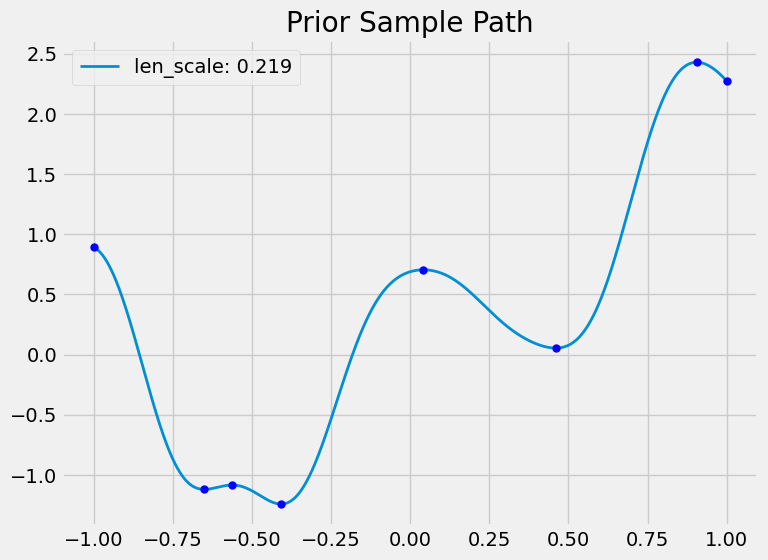

In [36]:
plot_prior_sample(TSRoots_instance.decoupled_gp, lb_normalized, ub_normalized, x_critical_points=x_critical, f_critical_points=func_x_critical)

Global minimization of $xsin(x)$ using BO via TS-roots

In [37]:
# Setting up parameters and initial conditions
k = 50 # BO iterations to be performed in the cell below
bo_iterMax = 100 # maximum BO iteration for this problem
xr_best, yr_best = TSRoots.extract_min(X_physical_space, Y_physical_space)
print(f"initial minimum point: {(xr_best.item(), yr_best.item())}")

initial minimum point: (-10.0, -5.440462152861783)


# We enumerate all possible combinations...


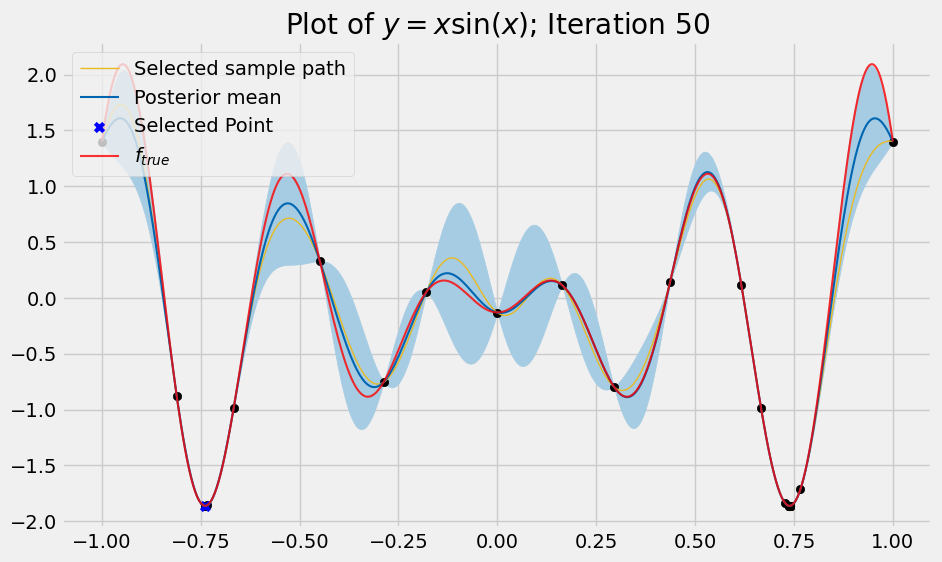

# BO iter = 50; y_best = -11.040707754015287...


In [38]:
# -----------
# BO loop
# -----------
plt.ion()  # Turn on interactive mode

for i in range(k):
    # Clear the output to display updated plot dynamically
    clear_output(wait=True)
    plt.figure(figsize=(10, 6))

    # Apply Bayesian Optimization policy using TS-roots
    # Instantiate TS-roots class (PS: the earlier instance of TS-roots was used for tutorial reasons), you just need to do this once.
    TSRoots_BO = TSRoots(X_normalized, Y_normalized.flatten(), lb_normalized, ub_normalized,
                           noise_level=noise_level, learning_rate=0.07, seed=seed)

    # Selects a new solution point using TSroots.
    x_new_normalized, y_new_normalized, _ = TSRoots_BO.xnew_TSroots()

    # Visualize the new solution point
    plt.scatter(x_new_normalized, y_new_normalized, color='blue', marker='x', linewidth=3.0, label='Selected Point')

    # Convert new point back to the physical space
    x_new_physical_space = unscale_Xn(x_new_normalized.reshape(-1, D), lb_x_physical, ub_x_physical)

    # Compute new observation value in the physical space
    y_new_physical_space, _ = generate_Ydata(f_objective_example, x_new_physical_space)

    # Append new raw data points
    X_physical_space = np.append(X_physical_space, x_new_physical_space).reshape(-1, D)
    Y_physical_space = np.append(Y_physical_space, y_new_physical_space)

    # Normalize updated data
    X_normalized = np.append(X_normalized, x_new_normalized).reshape(-1, D)
    Y_normalized = ((Y_physical_space - mean_Y_true) / std_Y_true) + np.random.normal(0, TSRoots_BO.decoupled_gp.sigman)

    # Extract the best-found solution so far
    xr_best, yr_best = TSRoots.extract_min(X_physical_space, Y_physical_space)

    # plot the true function to better capture the global minimum convergence
    plt.plot(X_normalized_plot, Y_normalized_plot, linestyle="-", linewidth=1.5, color="#FF0000", alpha=.8,
                 label=f'$f_{{true}}$')

    # Optionally, add legend and show the plot
    plt.legend(loc='upper left')

    # Add title in latex format
    plt.title(f'Plot of $y = x \sin(x)$; Iteration {i+1}')

    plt.show()

    # Report the best-found solution at each iteration
    if i < bo_iterMax:
        print(f"# BO iter = {i + 1}; y_best = {yr_best}...")
    else:
        print(f"# BO iter = {i + 1}; y_best = {yr_best}##.")

    # # Show the plot dynamically
    # plt.draw()

    # Pause to allow for plot display at each iteration
    plt.pause(0.5)

#### <span style="color:red">References</span>

[1] James Wilson, Viacheslav Borovitskiy, Alexander Terenin, Peter Mostowsky, and Marc Deisenroth. Efficiently sampling functions from Gaussian process posteriors. In Hal Daumé III and Aarti Singh, editors, _Proceedings of the 37th International Conference on Machine Learning, volume 119 of Proceedings of Machine Learning Research,_ pages 10292–10302. PMLR, 13–18 Jul 2020.
